In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import logic.gwyfile as gwyfile
from logic.gwyfile.objects import GwyContainer, GwyDataField

Define Dataset for analyses

In [3]:
path = 'G:\\Data\\Qudi_Data\\2023\\05\\20230508\\AttoDRY2200_Pi3_SPM\\'
filebeginning = '20230508-1839-00_FST_' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

Load Data from pickel

In [4]:
with open(filepath+'qafm_array_raw.pickle', 'rb') as f:
    qafm_data = pickle.load(f)
with open(filepath+'esr_array_raw.pickle', 'rb') as f:
    esr_data = pickle.load(f)

Load current data from qafm logic

In [ ]:
qafm_data = afm_scanner_logic._qafm_scan_array
esr_data = afm_scanner_logic._esr_scan_array

Analyse ESR Data with Lorentzian

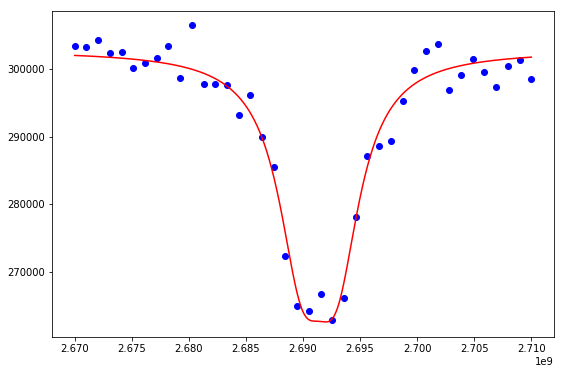

In [5]:
#Analyse single spectrum
#Gathering data from dictonary
data = esr_data['esr_fw']['data']
var_list = esr_data['esr_fw']['coord2_arr']
i = 0
j = 0
mode = 'N15'

#Determine fit

if mode == 'double':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N15':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
elif mode == 'N14':
    fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
    lm,_ = fitlogic.make_lorentziandouble_model()
    
else:    
    fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
    lm,_ = fitlogic.make_lorentzian_model()

#print(fit.fit_report())
#fit.params['center'].value

#Plot Data and fit
plt.plot(var_list,data[i,j],'bo')

x = np.linspace(var_list[0],var_list[-1],10000, endpoint=True)
plt.plot(x, lm.eval(fit.params, x=x),'r-')

plt.show()

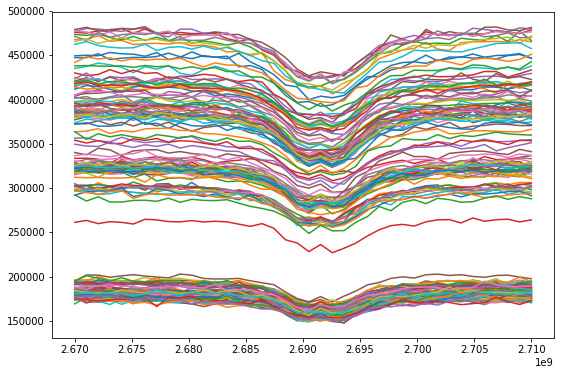

In [6]:
#Analyse multiple spectra
#Gathering data from dictonary
data = esr_data['esr_fw']['data']
var_list = esr_data['esr_fw']['coord2_arr']
coord0_num = qafm_data['Height(Dac)_fw']['params']['coord0_num (#)']
coord1_num = qafm_data['Height(Dac)_fw']['params']['coord1_num (#)']

for i in range(coord0_num):
    plt.plot(var_list,data[0,i])
plt.show()

In [31]:
#Analyse scan with Lorentzian fit and determine magnetic field
#Gathering data from dictonary
data = esr_data['esr_fw']['data']
var_list = esr_data['esr_fw']['coord2_arr']
coord0_num = qafm_data['Height(Dac)_fw']['params']['coord0_num (#)']
coord1_num = qafm_data['Height(Dac)_fw']['params']['coord1_num (#)']
res_freq = np.zeros((coord1_num,coord0_num)) #in Hz from the fit
b_field = np.zeros((coord1_num,coord0_num))
error_array = np.zeros((coord1_num,coord0_num))

#Define parameters for magnetic field calculation
gyro_nv = 28e9 #in Hz/T
e_field = 0 #in Hz
zero_field = 2.88e9 #in Hz, watch the Temperature

#Define the measured peak properties
mode = 'N15'
gslac = True
left = True

for i in range(coord1_num):
    for j in range(coord0_num):
        
        #Determine fit
        try:
            if mode == 'double':
                fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_dip)
                res_freq[i,j] = fit.params['l0_center'].value + (fit.params['l1_center'].value-fit.params['l0_center'].value)/2
                
            elif mode == 'N15':
                fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N15)
                res_freq[i,j] = fit.params['l0_center'].value + (fit.params['l1_center'].value-fit.params['l0_center'].value)/2
                
            elif mode == 'N14':
                fit = afm_scanner_logic._fitlogic.make_lorentziandouble_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentziandouble_N14)
                res_freq[i,j] = fit.params['l0_center'].value
            else:    
                fit = afm_scanner_logic._fitlogic.make_lorentzian_fit(var_list,data[i,j],estimator=afm_scanner_logic._fitlogic.estimate_lorentzian_dip)
                res_freq[i,j] = fit.params['center'].value
        
        except:
            error_array[i,j] = 1
            
if gslac == True and left == True:
    b_field = np.sqrt(abs(res_freq + zero_field)**2 - e_field**2) / gyro_nv
else:
    b_field = np.sqrt(abs(res_freq - zero_field)**2 - e_field**2) / gyro_nv

In [5]:
#Load esr array with B field from pickel
with open(filepath+'esr_array_bfield_T.pickle', 'rb') as f:
    esr_data = pickle.load(f)
b_field = esr_data['esr_fw']['b_field']

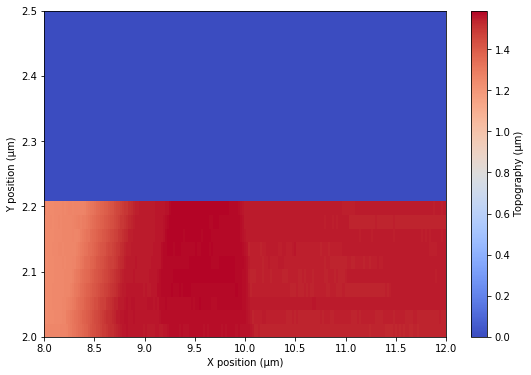

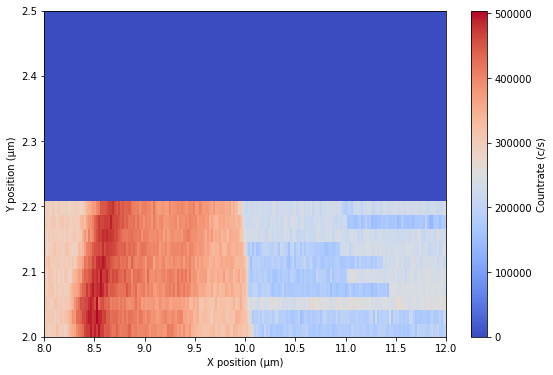

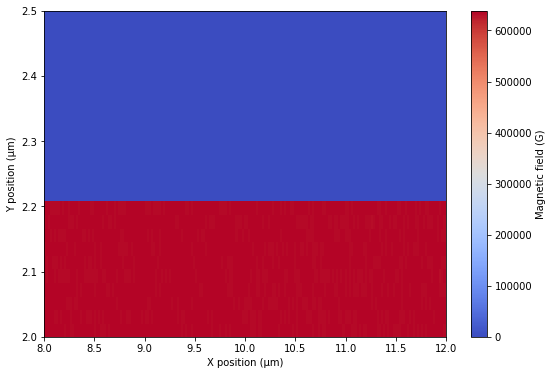

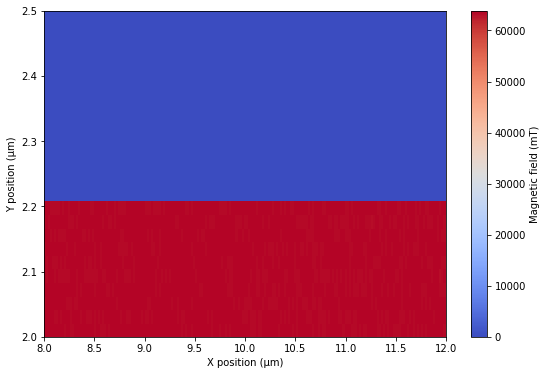

In [7]:
#Plot analysed Data
x = qafm_data['Height(Dac)_fw']['coord0_arr']*10**6
y = qafm_data['Height(Dac)_fw']['coord1_arr']*10**6

low_centile = 0
high_centile = 100
plt.pcolormesh(x,y,qafm_data['Height(Dac)_fw']['data']*10**6,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(qafm_data['Height(Dac)_fw']['data']*10**6, low_centile), vmax = np.nanpercentile(qafm_data['Height(Dac)_fw']['data']*10**6, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Topography (\u03BCm)')
plt.show()

low_centile = 0
high_centile = 100
plt.pcolormesh(x,y,qafm_data['counts_fw']['data'],cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(qafm_data['counts_fw']['data'], low_centile), vmax = np.nanpercentile(qafm_data['counts_fw']['data'], high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Countrate (c/s)')
plt.show()

low_centile = 0.75
high_centile = 99.8
plt.pcolormesh(x,y,b_field*10**4,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(b_field*10**4, low_centile), vmax = np.nanpercentile(b_field*10**4, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Magnetic field (G)')
plt.show()

low_centile = 0.75
high_centile = 99.8
plt.pcolormesh(x,y,b_field*10**3,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(b_field*10**3, low_centile), vmax = np.nanpercentile(b_field*10**3, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Magnetic field (mT)')
plt.show()

In [10]:
qafm_data['Height(Dac)_fw']['coord1_arr']

array([2.00000000e-06, 2.02083333e-06, 2.04166667e-06, 2.06250000e-06,
       2.08333333e-06, 2.10416667e-06, 2.12500000e-06, 2.14583333e-06,
       2.16666667e-06, 2.18750000e-06, 2.20833333e-06, 2.22916667e-06,
       2.25000000e-06, 2.27083333e-06, 2.29166667e-06, 2.31250000e-06,
       2.33333333e-06, 2.35416667e-06, 2.37500000e-06, 2.39583333e-06,
       2.41666667e-06, 2.43750000e-06, 2.45833333e-06, 2.47916667e-06,
       2.50000000e-06])

In [7]:
#Save Topo and Counts as png as needed
x = qafm_data['Height(Dac)_fw']['coord0_arr']*10**6
y = qafm_data['Height(Dac)_fw']['coord1_arr']*10**6
low_centile = 0
high_centile = 100
plt.pcolormesh(x,y,qafm_data['Height(Dac)_fw']['data']*10**6,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(qafm_data['Height(Dac)_fw']['data']*10**6, low_centile), vmax = np.nanpercentile(qafm_data['Height(Dac)_fw']['data']*10**6, high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Topography (\u03BCm)')
plt.tight_layout()
with open(filepath+'QAFM_Height(Dac)_fw_fig_corrected.png', 'wb') as f:
    plt.savefig(f,format='png')
with open(filepath+'QAFM_Height(Dac)_fw_fig_corrected.pdf', 'wb') as f:
    plt.savefig(f,format='pdf')    
plt.show()
    
low_centile = 0
high_centile = 100
plt.pcolormesh(x,y,qafm_data['counts_fw']['data'],cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(qafm_data['counts_fw']['data'], low_centile), vmax = np.nanpercentile(qafm_data['counts_fw']['data'], high_centile))
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Countrate (c/s)')
plt.tight_layout()
with open(filepath+'QAFM_counts_fw_fig_corrected.png', 'wb') as f:
    plt.savefig(f,format='png')
with open(filepath+'QAFM_counts_fw_fig_corrected.pdf', 'wb') as f:
    plt.savefig(f,format='pdf')
plt.show()

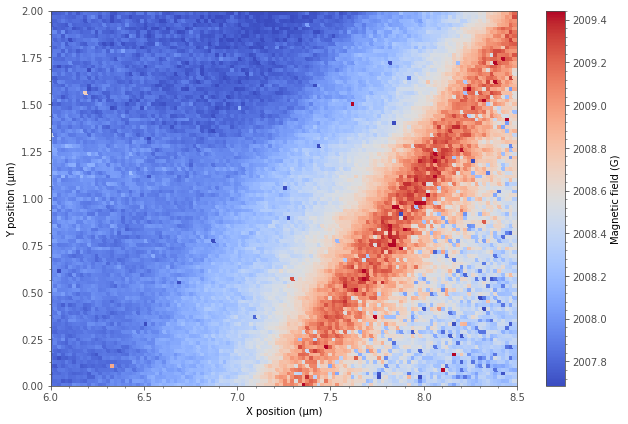

In [27]:
#Save b field image in Gauss
x = qafm_data['Height(Dac)_fw']['coord0_arr']*10**6
y = qafm_data['Height(Dac)_fw']['coord1_arr']*10**6
low_centile = 0.75
high_centile = 99.8
plt.pcolormesh(x,y,b_field*10**4,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(b_field*10**4, low_centile), vmax = np.nanpercentile(b_field*10**4, high_centile),edgecolors = 'face')
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Magnetic field (G)')
plt.tight_layout()
with open(filepath+'QAFM_b_field_fw_fig_corrected.png', 'wb') as f:
    plt.savefig(f,format='png')
with open(filepath+'QAFM_b_field_fw_fig_corrected.pdf', 'wb') as f:
    plt.savefig(f,format='pdf')
with open(filepath+'QAFM_b_field_fw_fig_corrected.svg', 'wb') as f:
    plt.savefig(f,format='svg')
plt.show()

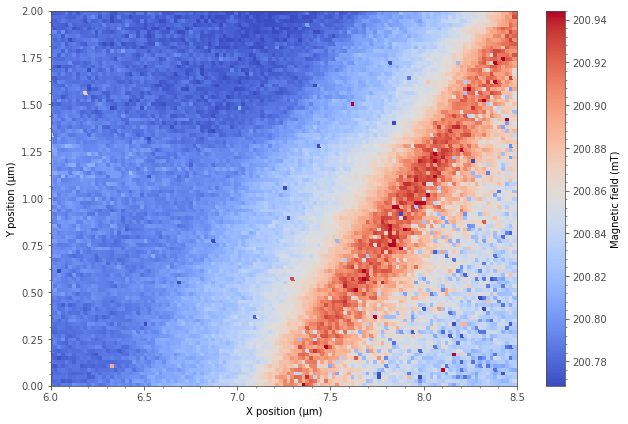

In [28]:
#Save b field image in mT
x = qafm_data['Height(Dac)_fw']['coord0_arr']*10**6
y = qafm_data['Height(Dac)_fw']['coord1_arr']*10**6
low_centile = 0.75
high_centile = 99.8
plt.pcolormesh(x,y,b_field*10**3,cmap=plt.cm.get_cmap('coolwarm'), vmin =np.nanpercentile(b_field*10**3, low_centile), vmax = np.nanpercentile(b_field*10**3, high_centile),edgecolors = 'face')
plt.xlabel('X position (\u03BCm)')
plt.ylabel('Y position (\u03BCm)')
plt.colorbar(label = 'Magnetic field (mT)')
plt.tight_layout()
with open(filepath+'QAFM_b_field_fw_mT_fig_corrected.png', 'wb') as f:
    plt.savefig(f,format='png')
with open(filepath+'QAFM_b_field_fw_mT_fig_corrected.pdf', 'wb') as f:
    plt.savefig(f,format='pdf')
with open(filepath+'QAFM_b_field_fw_mT_fig_corrected.svg', 'wb') as f:
    plt.savefig(f,format='svg')
plt.show()

In [ ]:
#Save calculated B field to pickel
esr_array = esr_data
esr_array['esr_fw']['b_field'] = b_field
with open(filepath+'esr_array_bfield_T.pickle', 'wb') as f:
    pickle.dump(esr_array, f)